<a href="https://colab.research.google.com/github/susuro342/datamining/blob/master/titanic_prac2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic: Machine Learning from Disaster

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# 데이터 분석
import pandas as pd
import numpy as np
import random as rnd

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 기계 학습
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

## 데이터 로딩 및 확인

In [0]:
# 데이터 로딩
train_df = pd.read_csv('/content/drive/My Drive/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/test.csv')
combine = [train_df, test_df]

In [74]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [75]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [76]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [77]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [78]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Missing Value 처리

In [79]:
# check missing values in train dataset
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [80]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

###### 속성에 값이 없는 샘플들이 존재. 그 중 Age, Cabin에 missing value(누락값)가 많이 발견됨 전체에서 몇프로나 차지하는 지 확인해보자.

In [81]:
# Age에 누락값이 있는 샘플의 비율
sum(pd.isnull(train_df['Age']))/len(train_df["PassengerId"])

0.19865319865319866

In [82]:
# Cabin에 누락값이 있는 샘플의 비율
sum(pd.isnull(train_df['Cabin']))/len(train_df["PassengerId"])

0.7710437710437711

###### Age는 20%의 샘플에서 누락, Cabin은 77%의 샘플에서 누락. Age는 누락된 값을 채워넣고, Cabin은 아예 feature를 버리는게 낫겠다.

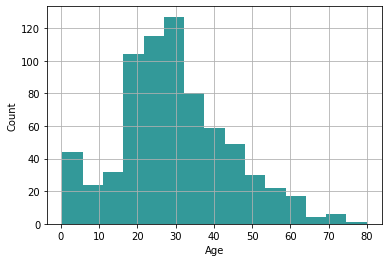

In [83]:
# Age가 어떻게 분포되어 있는지 히스토그램으로 확인해보자.
ax = train_df["Age"].hist(bins=15, color='teal', alpha=0.8)
ax.set(xlabel='Age', ylabel='Count')
plt.show()

In [84]:
# 그럼 Age의 중간값은 얼마일까?
train_df["Age"].median(skipna=True)

28.0

###### 누락된 값들에 그냥 중간값을 일괄적으로 채워넣는 것이 좋아보인다. 남은 것은 train에서 Embarked, test에서 Fare

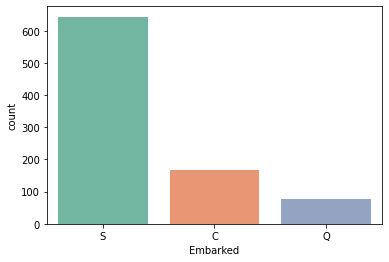

In [85]:
# train set에서 Embarked 의 분포를 확인해보자.
sns.countplot(x='Embarked',data=train_df,palette='Set2')
plt.show()

In [86]:
# Fare는 가격, 그럼 평균값은?
train_df["Fare"].mean(skipna=True)

32.2042079685746

###### Embarked는 S가 가장 많으니 누락값에 S를 채워넣으면 무난하겠다.
###### Fare는 승선한 항구와 티켓 등급에 따라 다르겠지만 편이상 평균값인 32를 취해서 누락값에 넣는 것을 채택하겠다.

## 데이터 전처리: 속성에 따라 누락된 값을 채워 넣거나 속성 자체 제거

In [0]:
# 누락된 값을 적절한 값으로 채워넣기
train_df["Age"].fillna(28, inplace=True)
test_df["Age"].fillna(28, inplace=True)
train_df["Embarked"].fillna("S", inplace=True)
test_df["Fare"].fillna(32, inplace=True)


# 누락된 값이 너무 많은 속성 제거
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

## 데이터 속성별 값에 따라 생존자 확인


In [88]:
# 객실 등급에 따른 생존자 확률
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [89]:
# 성별에 따른 생존자 확률
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [90]:
# 가족, 친척의 명수에 따른 생존자 확률
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [91]:
# 부모자식 관계에 있는 사람의 명수에 따른 생존자 확률
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## 데이터 시각화

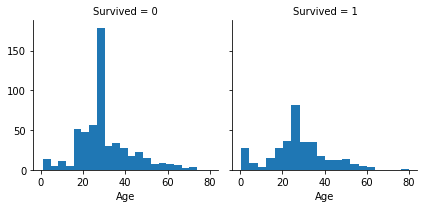

In [92]:
# 나이별 비생존자와 생존자
g = sns.FacetGrid(train_df, col='Survived') # 열에 생존자 0/1 
g.map(plt.hist, 'Age', bins=20)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


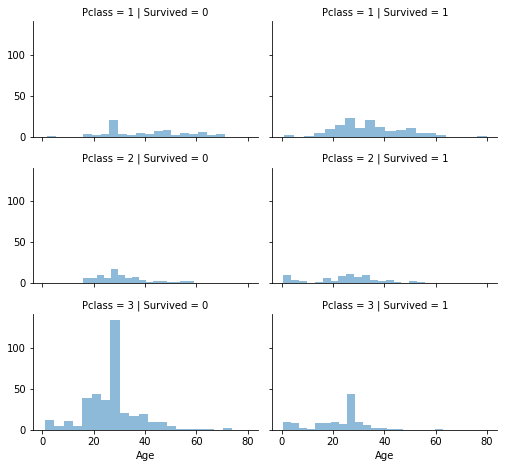

In [93]:
# 나이별 객실 등급별 비생존자와 생존자
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6) # 열에 생존자, 행에 객실 등급 
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


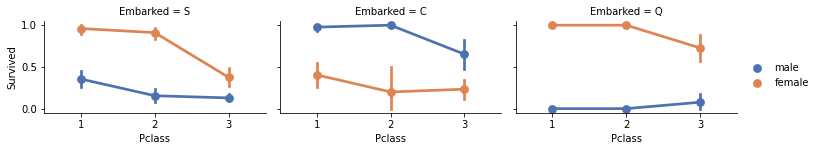

In [94]:
#이번에는 히스토그램이 아닌 꺾은선 그래프
grid = sns.FacetGrid(train_df, col='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=[1, 2, 3], hue_order=None)
grid.add_legend()

## 데이터 전처리: 속성 조정

In [95]:
# 우선 현재 보유하고 있는 속성을 다시 한 번 확인해보자
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


###### 속성 조정
1. PassengerId는 샘플별로 다르기 때문에 제거
2. Survived 는 예측해야할 output
3. Age, Fare는 그대로 채택
4. Sex, Pclass, Embarked는 카테고리 값이므로 처리.
5. SibSp, Parch 는 Binary 값으로 수정
6. Ticket은 표 번호이므로 상관성이 거의 없는 값이라 제거
7. Name은 한 번 살펴볼 것.

### 데이터 전처리 : 속성 조정 - SibSp, Parch 는 Binary 값으로 수정

In [0]:
# 신규 속성인 TravelSibSp, TravelParch 만들어줌
# 해당 속성이 0보다 크면 1, 아니면 0
train_df['TravelSibSp'] = np.where(train_df['SibSp']>0, 1, 0)
train_df['TravelParch'] = np.where(train_df['Parch']>0, 1, 0)
# 이후 SibSp, SibSp 제거
train_df.drop('SibSp', axis=1, inplace=True)
train_df.drop('Parch', axis=1, inplace=True)


In [0]:
# test 데이터도 마찬가지로 적용
test_df['TravelSibSp'] = np.where(test_df['SibSp']>0, 1, 0)
test_df['TravelParch'] = np.where(test_df['Parch']>0, 1, 0)
test_df.drop('SibSp', axis=1, inplace=True)
test_df.drop('Parch', axis=1, inplace=True)

### 데이터 전처리 : 속성 조정 - 카테고리 속성인 Pclass, Embarked, Sex 처리

어떻게? Pclass에 세 가지가 있으니 Pclass 라는 속성을 세 개로 쪼갠다. Pclass_1, Pclass_2, Pclass_3

Embarked도 마찬가지. S, C, Q 가 있으니 Embarked_S, Embarked_C, Embarked_Q

Sex도 마찬가지, female, male 이 있으니 Sex_female, Sex_femal

In [99]:
# Pcalss를 위한 새로운 카테고리 속성을 만들어 새롭게 저장 (train_df2)
train_df2 = pd.get_dummies(train_df, columns=["Pclass"])

# Embarked를 위한 새로운 카테고리 속성을 만들어 새롭게 저장 (train_df3)
train_df3 = pd.get_dummies(train_df2, columns=["Embarked"])

# Sex를 위한 새로운 카테고리 속성을 만들어 새롭게 저장 (train_df3)
train_df4 = pd.get_dummies(train_df3, columns=["Sex"])

# 결과 확인
train_df4.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,TravelSibSp,TravelParch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,1,0,0,0,1,0,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71.2833,1,0,1,0,0,1,0,0,1,0
2,3,1,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,0,0,0,0,1,0,0,1,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,1,0,1,0,0,0,0,1,1,0
4,5,0,"Allen, Mr. William Henry",35.0,373450,8.0500,0,0,0,0,1,0,0,1,0,1


###### 그런데 여기서, Sex_female, Sex_male 이 모두 필요할까? 어짜피 같은 정보를 갖고 있으므로 둘 중 하나만 있으면 되지 않는가? 따라서 둘 중 하나를 삭제


### 데이터 전처리 : 속성 조정 - 쓸모없는 속성 제거

In [100]:
train_df4.drop('PassengerId', axis=1, inplace=True)
train_df4.drop('Name', axis=1, inplace=True)
train_df4.drop('Ticket', axis=1, inplace=True)
train_df4.drop('Sex_male', axis=1, inplace=True)
train_df4.head()

,Survived,Age,Fare,TravelSibSp,TravelParch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female
0,0,22.0,7.2500,1,0,0,0,1,0,0,1,0
1,1,38.0,71.2833,1,0,1,0,0,1,0,0,1
2,1,26.0,7.9250,0,0,0,0,1,0,0,1,1
3,1,35.0,53.1000,1,0,1,0,0,0,0,1,1
4,0,35.0,8.0500,0,0,0,0,1,0,0,1,0


### 데이터 전처리 : 위의 속성 조정을 이젠 test_df에도 모두 해주자

In [101]:
test_df2 = pd.get_dummies(test_df, columns=["Pclass"])
test_df3 = pd.get_dummies(test_df2, columns=["Embarked"])
test_df4 = pd.get_dummies(test_df3, columns=["Sex"])

#test_df4.drop('PassengerId', axis=1, inplace=True) <--- 이건 나중에 평가를 위해 일단 지금은 지우지 말자
test_df4.drop('Name', axis=1, inplace=True)
test_df4.drop('Ticket', axis=1, inplace=True)
test_df4.drop('Sex_male', axis=1, inplace=True)
test_df4.head()

,PassengerId,Age,Fare,TravelSibSp,TravelParch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female
0,892,34.5,7.8292,0,0,0,0,1,0,1,0,0
1,893,47.0,7.0000,1,0,0,0,1,0,0,1,1
2,894,62.0,9.6875,0,0,0,1,0,0,1,0,0
3,895,27.0,8.6625,0,0,0,0,1,0,0,1,0
4,896,22.0,12.2875,1,1,0,0,1,0,0,1,1


###### 이제 드디어 데이터 준비는 모두 끝났다!!!!!!!!

# Machine Learning 기법을 활용한 생존자 예측
## 활용 모델

Logistic Regression

k-Nearest Neighbors

Support Vector Machines

Naive Bayes classifier

Decision Tree

Artificial neural network

In [103]:
# 우선 학습 집합과 테스트 집합을 준비한다.
X_train = train_df4.drop("Survived", axis=1)
Y_train = train_df4["Survived"]
X_test  = test_df4.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 11), (891,), (418, 11))

## Support Vector Machines

In [104]:
# SVM 모델 학습
svc = SVC()
svc.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [105]:
# 테스트 데이터에 대해 예측
Y_pred_svc = svc.predict(X_test)
# 테스트 데이터를 현재 레이블이 없으므로 학습 데이터에 대해 예측한 정확도 측정
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

68.24

## Logistic Regression

In [106]:
# Logistic Regression training
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
# Logistic Regression prediction
Y_pred_logreg = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2) # training 데이터에 대해 예측 정확도 구함
acc_log

80.02

In [109]:
# 속성별 상관 계수
coeff_df  =  pd.DataFrame(train_df4.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
10,Sex_female,2.504462
4,Pclass_1,1.007365
7,Embarked_C,0.191378
8,Embarked_Q,0.147112
5,Pclass_2,0.141568
1,Fare,0.000992
0,Age,-0.032675
3,TravelParch,-0.059402
2,TravelSibSp,-0.111681
9,Embarked_S,-0.329006


## k-Nearest Neighbor

In [110]:
knn  = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.29

## Naive Bayes classifiers

In [111]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_NB = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

75.65

## Decision tree

In [112]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_DT = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

97.98

## Artificial Neural Network

In [114]:
ANN = MLPClassifier(solver='lbfgs', alpha=1, hidden_layer_sizes=(10, 30), random_state=1)
ANN.fit(X_train, Y_train)
Y_pred_ANN = ANN.predict(X_test)
acc_ANN = round(ANN.score(X_train, Y_train) * 100, 2)
acc_ANN

80.36

## 최종 결과 저장

In [0]:
Y_pred = Y_pred_DT

submission = pd.DataFrame({
        "PassengerId": test_df4["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('/content/drive/My Drive/submission.csv', index=False)